#Prepare env


In [1]:
# install dependencies: (use cu111 because colab has CUDA 11.1) no need 
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmdetection
!pip install mmdet

# Install mmrotate
!rm -rf mmrotate
!git clone https://github.com/open-mmlab/mmrotate.git
%cd mmrotate
!pip install -e .

# switch branch
!git checkout dev
!git branch -a

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.4 MB/s eta 0:14:28tcmalloc: large alloc 1147494400 bytes == 0x39794000 @  0x7f809b0bf615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████▌               | 1055.7 MB 1.3 MB/s eta 0:12:51tcmalloc: large alloc 1434370048 bytes == 0x7ddea000 @  0x7f809b0bf615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████

In [3]:
%cd mmrotate

/content/mmrotate


In [4]:
from mmcv import collect_env
collect_env()

{'CUDA available': True,
 'CUDA_HOME': '/usr/local/cuda',
 'GCC': 'x86_64-linux-gnu-gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0',
 'GPU 0': 'Tesla T4',
 'MMCV': '1.5.2',
 'MMCV CUDA Compiler': '11.1',
 'MMCV Compiler': 'GCC 7.3',
 'NVCC': 'Cuda compilation tools, release 11.1, V11.1.105',
 'OpenCV': '4.1.2',
 'PyTorch': '1.9.0+cu111',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 7.3\n  - C++ Version: 201402\n  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v2.1.2 (Git Hash 98be7e8afa711dc9b66c8ff3504129cb82013cdb)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 11.1\n  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=comp

In [5]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMRotate installation
import mmrotate
print(mmrotate.__version__)

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.9.0+cu111 True
0.3.1
2.25.0
11.1
GCC 7.3


# MAIN code


In [4]:
# We download the pre-trained checkpoints for inference and finetuning.
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmrotate/v0.1.0/oriented_rcnn/oriented_rcnn_r50_fpn_1x_dota_le90/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth \
      -O checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth

--2022-06-15 06:35:20--  https://download.openmmlab.com/mmrotate/v0.1.0/oriented_rcnn/oriented_rcnn_r50_fpn_1x_dota_le90/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 165749436 (158M) [application/octet-stream]
Saving to: ‘checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth’

checkpoints/oriente 100%[===================>] 158.07M  8.95MB/s    in 18s     

2022-06-15 06:35:39 (8.62 MB/s) - ‘checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth’ saved [165749436/165749436]



In [6]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

# Choose to use a config and initialize the detector
config = 'configs/oriented_rcnn/oriented_rcnn_r50_fpn_1x_dota_le90.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth'

# Set the device to be used for evaluation
device='cuda:0'

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

/usr/local/lib/python3.7/dist-packages/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '


load checkpoint from local path: checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth


OrientedRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [6]:
# Use the detector to do inference
img = 'demo/demo.jpg'
result = inference_detector(model, img)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '


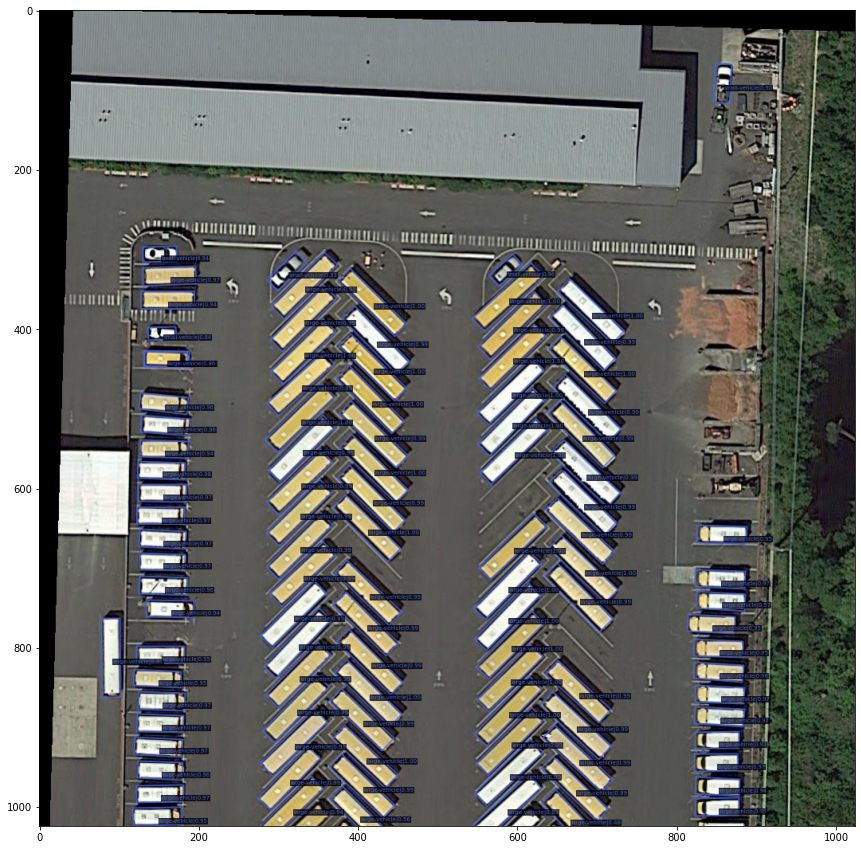

In [7]:
# Let's plot the result
import mmcv
import matplotlib.pyplot as plt

model.show_result(img, result, score_thr=0.3, out_file='./det.jpeg')
img = mmcv.imread('./det.jpeg')
plt.figure(figsize=(20, 15))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [8]:
# Use the detector to do inference
from mmrotate.apis import inference_detector_by_patches
img = 'demo/dota_demo.jpg'
result = inference_detector_by_patches(model, img, [1024], [824], [1.0], 0.1)

/usr/local/lib/python3.7/dist-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '


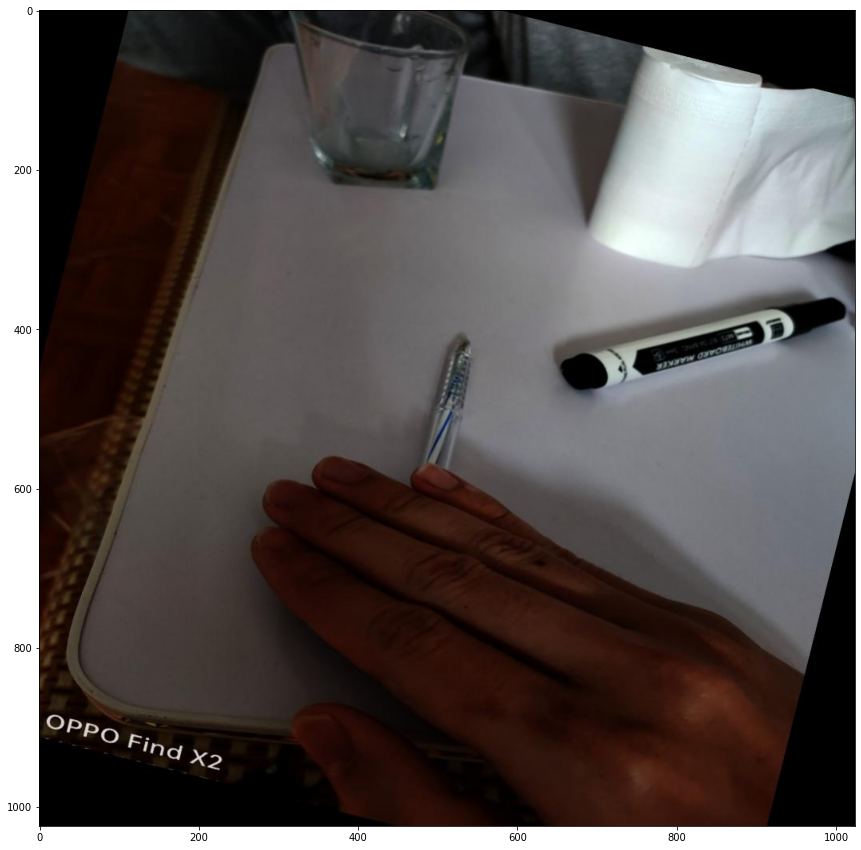

In [13]:
# Let's plot the result
import mmcv
import matplotlib.pyplot as plt

model.show_result(img, result, score_thr=0.3, out_file='./det_huge.jpeg')
img = mmcv.imread('./det_huge.jpeg')
plt.figure(figsize=(20, 15))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

##TRAIN


In [ ]:
# download, decompress the data
# !wget https://download.openmmlab.com/mmrotate/data/ssdd_tiny.zip
# !unzip ssdd_tiny.zip > /dev/null

# roboflow data set as obb_yolov5 format
!wget https://app.roboflow.com/ds/qRzqab60s1?key=pt5tPBpRhf -O dataset.zip
!unzip  dataset.zip  -d /content/mmrotate/dataset

In [21]:
# Install tree first
!apt-get -q install tree
!tree dataset

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (100 kB/s)
Selecting previously unselected package tree.
(Reading database ... 155632 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
dataset
├── data.yaml
├── README.dataset.txt
├── README.roboflow.txt
├── train
│   ├── images
│   │   ├── IMG20220423082655_jpg.rf.269efd47f6a6d0143cce9ee0cdc7

In [ ]:
# Install tree first
!apt-get -q install tree
!tree ssdd_tiny/

Reading package lists...
Building dependency tree...
Reading state information...
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (148 kB/s)
Selecting previously unselected package tree.
(Reading database ... 155203 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
ssdd_tiny/
├── images
│   ├── 000001.png
│   ├── 000009.png
│   ├── 000011.png
│   ├── 000029.png
│   ├── 000041.png
│   ├── 00004

In [12]:
# Let's take a look at the dataset image
img = mmcv.imread('dataset/train/images/IMG20220423083147_jpg.rf.46953dadfdd4223fcd5be8252b0d3651.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

NameError: ignored

In [23]:
# Check the label of a single image
# !cat ssdd_tiny/train/000631.txt
!cat dataset/train/labelTxt/IMG20220423083147_jpg.rf.46953dadfdd4223fcd5be8252b0d3651.txt

1012.8500086264685 349.8519971518129 1025.9217198531842 409.2831453179766 651.345123124891 491.66123551068927 638.2750069999602 432.23147000000796 pen 0
471 398 558 398 558 576 471 576 pen 0

In [7]:
from mmrotate.datasets.builder import ROTATED_DATASETS
from mmrotate.datasets.dota import DOTADataset


@ROTATED_DATASETS.register_module()
class TinyDataset(DOTADataset):
    """SAR ship dataset for detection."""
    CLASSES = ('pen',)

In [8]:
from mmcv import Config
cfg = Config.fromfile('/content/mmrotate/configs/oriented_rcnn/oriented_rcnn_r50_fpn_1x_dota_le90.py')
cfg.device='cuda'

In [15]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'TinyDataset'
cfg.data_root = 'dataset/'

cfg.data.test.type = 'TinyDataset'
cfg.data.test.data_root = 'dataset/valid'
cfg.data.test.ann_file = 'labelTxt'
cfg.data.test.img_prefix = 'images'

cfg.data.train.type = 'TinyDataset'
cfg.data.train.data_root = 'dataset/train/'
cfg.data.train.ann_file = 'labelTxt'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'TinyDataset'
cfg.data.val.data_root = 'dataset/valid/'
cfg.data.val.ann_file = 'labelTxt'
cfg.data.val.img_prefix = 'images'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 1
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = '/content/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

cfg.optimizer.lr = 0.001
cfg.lr_config.warmup = None
cfg.runner.max_epochs = 10
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 3
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 3

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
dataset_type = 'TinyDataset'
data_root = 'dataset/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='RResize', img_scale=(1024, 1024)),
    dict(
        type='RRandomFlip',
        flip_ratio=[0.25, 0.25, 0.25],
        direction=['horizontal', 'vertical', 'diagonal'],
        version='le90'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        flip=False,
        transforms=[
            dict(type='RResize'),
            dict(
                type='No

In [ ]:
cfg.model.backbone ={'type':'ResNet',
        'depth':18,
        'norm_eval':False,
        'norm_cfg':dict(type='BN'),
        'init_cfg':dict(type='Pretrained', checkpoint='torchvision://resnet18')}
cfg.model.neck=dict(
        type='FPN',
        in_channels=[64, 128, 256, 512],
        out_channels=256,
        num_outs=5)



In [16]:
import os.path as osp
import mmcv
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/usr/local/lib/python3.7/dist-packages/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '
2022-06-15 07:02:35,438 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-06-15 07:02:35,444 - mmdet - INFO - load checkpoint from local path: /content/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
2022-06-15 07:02:35,579 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([16, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([2]).
2022-06-15 07:02:35,594 - mmdet - INFO - Start runni

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 5.2 task/s, elapsed: 1s, ETA:     0s

2022-06-15 07:03:51,023 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| pen   | 19  | 99   | 0.895  | 0.776 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.776 |
+-------+-----+------+--------+-------+
2022-06-15 07:03:51,025 - mmdet - INFO - Epoch(val) [3][7]	mAP: 0.7758
2022-06-15 07:03:59,863 - mmdet - INFO - Epoch [4][10/30]	lr: 1.000e-03, eta: 0:02:30, time: 0.882, data_time: 0.248, memory: 4019, loss_rpn_cls: 0.0024, loss_rpn_bbox: 0.0374, loss_cls: 0.0995, acc: 94.7852, loss_bbox: 0.0672, loss: 0.2065, grad_norm: 1.6605
2022-06-15 07:04:06,277 - mmdet - INFO - Epoch [4][20/30]	lr: 1.000e-03, eta: 0:02:20, time: 0.641, data_time: 0.010, memory: 4019, loss_rpn_cls: 0.0037, loss_rpn_bbox: 0.0133, loss_cls: 0.0928, acc: 95.8496, loss_bbox: 0.0583, loss: 0.1681, grad_norm: 1.2760
2022-06-15 07:04:12,723 - mmdet - INFO - Epoch [4][30/30]	lr: 1.000e-03, eta: 0:02:11, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 5.2 task/s, elapsed: 1s, ETA:     0s

2022-06-15 07:05:06,170 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| pen   | 19  | 119  | 1.000  | 0.926 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.926 |
+-------+-----+------+--------+-------+
2022-06-15 07:05:06,172 - mmdet - INFO - Epoch(val) [6][7]	mAP: 0.9259
2022-06-15 07:05:15,022 - mmdet - INFO - Epoch [7][10/30]	lr: 1.000e-03, eta: 0:01:21, time: 0.883, data_time: 0.246, memory: 4019, loss_rpn_cls: 0.0029, loss_rpn_bbox: 0.0095, loss_cls: 0.0704, acc: 97.5684, loss_bbox: 0.0581, loss: 0.1409, grad_norm: 1.3939
2022-06-15 07:05:21,427 - mmdet - INFO - Epoch [7][20/30]	lr: 1.000e-03, eta: 0:01:13, time: 0.640, data_time: 0.010, memory: 4019, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0306, loss_cls: 0.0720, acc: 97.5879, loss_bbox: 0.0498, loss: 0.1540, grad_norm: 1.6339
2022-06-15 07:05:27,872 - mmdet - INFO - Epoch [7][30/30]	lr: 1.000e-03, eta: 0:01:06, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 5.2 task/s, elapsed: 1s, ETA:     0s

2022-06-15 07:06:20,920 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| pen   | 19  | 147  | 0.947  | 0.904 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.904 |
+-------+-----+------+--------+-------+
2022-06-15 07:06:20,922 - mmdet - INFO - Epoch(val) [9][7]	mAP: 0.9043
2022-06-15 07:06:29,779 - mmdet - INFO - Epoch [10][10/30]	lr: 1.000e-04, eta: 0:00:14, time: 0.884, data_time: 0.247, memory: 4019, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0208, loss_cls: 0.0686, acc: 97.7051, loss_bbox: 0.0586, loss: 0.1507, grad_norm: 1.5710
2022-06-15 07:06:36,220 - mmdet - INFO - Epoch [10][20/30]	lr: 1.000e-04, eta: 0:00:07, time: 0.644, data_time: 0.011, memory: 4019, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0244, loss_cls: 0.0725, acc: 97.6367, loss_bbox: 0.0482, loss: 0.1479, grad_norm: 1.4581
2022-06-15 07:06:42,701 - mmdet - INFO - Epoch [10][30/30]	lr: 1.000e-04, eta: 0:00:0

In [27]:
cfg.model

{'backbone': {'depth': 50,
  'frozen_stages': 1,
  'init_cfg': {'checkpoint': 'torchvision://resnet50', 'type': 'Pretrained'},
  'norm_cfg': {'requires_grad': True, 'type': 'BN'},
  'norm_eval': True,
  'num_stages': 4,
  'out_indices': (0, 1, 2, 3),
  'style': 'pytorch',
  'type': 'ResNet'},
 'neck': {'in_channels': [256, 512, 1024, 2048],
  'num_outs': 5,
  'out_channels': 256,
  'type': 'FPN'},
 'roi_head': {'bbox_head': {'bbox_coder': {'angle_range': 'le90',
    'edge_swap': True,
    'norm_factor': None,
    'proj_xy': True,
    'target_means': (0.0, 0.0, 0.0, 0.0, 0.0),
    'target_stds': (0.1, 0.1, 0.2, 0.2, 0.1),
    'type': 'DeltaXYWHAOBBoxCoder'},
   'fc_out_channels': 1024,
   'in_channels': 256,
   'loss_bbox': {'beta': 1.0, 'loss_weight': 1.0, 'type': 'SmoothL1Loss'},
   'loss_cls': {'loss_weight': 1.0,
    'type': 'CrossEntropyLoss',
    'use_sigmoid': False},
   'num_classes': 1,
   'reg_class_agnostic': True,
   'roi_feat_size': 7,
   'type': 'RotatedShared2FCBBoxHead'}

/usr/local/lib/python3.7/dist-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '


time inference: 0.29975342750549316


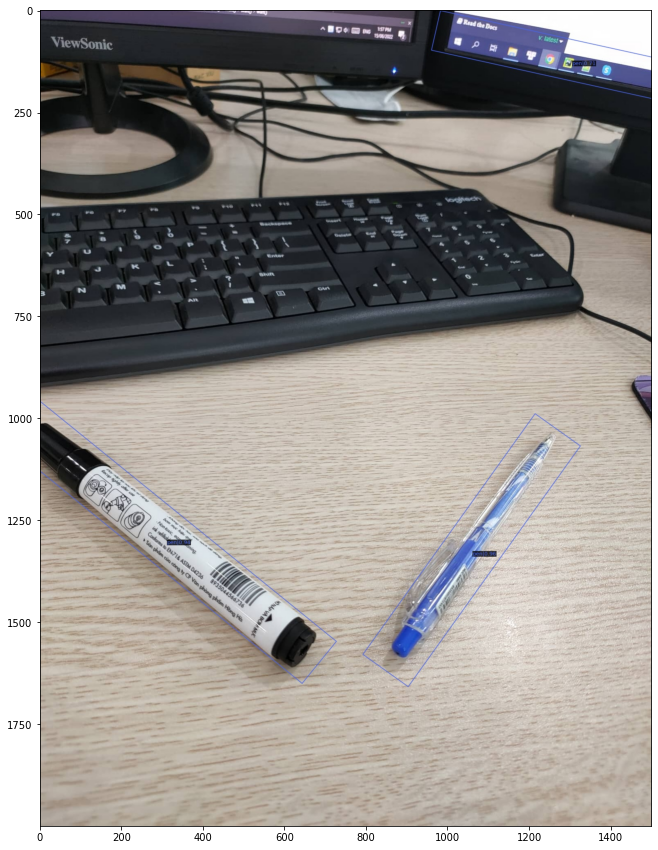

In [30]:
import time

img = mmcv.imread('/content/pen_detection.jpg')
model.cfg = cfg
start = time.time()
result = inference_detector(model, img)
print(f'time inference: {time.time() - start}')
model.show_result(img, result, score_thr=0.5, out_file='/content/result.jpeg')
img = mmcv.imread('/content/result.jpeg')
plt.figure(figsize=(20, 15))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

AttributeError: ignored

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
model.cfg

Config (path: /content/mmrotate/configs/oriented_rcnn/oriented_rcnn_r50_fpn_1x_dota_le90.py): {'dataset_type': 'TinyDataset', 'data_root': 'dataset/', 'img_norm_cfg': {'mean': [123.675, 116.28, 103.53], 'std': [58.395, 57.12, 57.375], 'to_rgb': True}, 'train_pipeline': [{'type': 'LoadImageFromFile'}, {'type': 'LoadAnnotations', 'with_bbox': True}, {'type': 'RResize', 'img_scale': (1024, 1024)}, {'type': 'RRandomFlip', 'flip_ratio': [0.25, 0.25, 0.25], 'direction': ['horizontal', 'vertical', 'diagonal'], 'version': 'le90'}, {'type': 'Normalize', 'mean': [123.675, 116.28, 103.53], 'std': [58.395, 57.12, 57.375], 'to_rgb': True}, {'type': 'Pad', 'size_divisor': 32}, {'type': 'DefaultFormatBundle'}, {'type': 'Collect', 'keys': ['img', 'gt_bboxes', 'gt_labels']}], 'test_pipeline': [{'type': 'LoadImageFromFile'}, {'type': 'MultiScaleFlipAug', 'img_scale': (1024, 1024), 'flip': False, 'transforms': [{'type': 'RResize'}, {'type': 'Normalize', 'mean': [123.675, 116.28, 103.53], 'std': [58.395, 